In [18]:
from braket.tracking import Tracker
t = Tracker().start()

In [19]:
from qiskit_braket_provider import AWSBraketProvider
provider = AWSBraketProvider()
provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

In [20]:
provider.backends(statuses=["ONLINE"], types=["QPU"])

[BraketBackend[Aria 1], BraketBackend[Forte 1], BraketBackend[ONLINE]]

In [21]:
backend = provider.get_backend("TN1")

In [22]:
print(backend)

BraketBackend[TN1]


In [23]:
import numpy as np
from qiskit_optimization import QuadraticProgram
#from qiskit_optimization.translators import from_docplex_mpl
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import BackendSampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
import matplotlib.pyplot as plt
import time

In [24]:
sampler = BackendSampler(
    backend=backend,
    skip_transpilation=False,
    options={"shots": 100}
)

In [25]:
#Number of buses and lines
num_buses = 14
num_lines = 20

#incidence matrix
incidence_matrix = np.zeros((num_buses, num_lines))

#transmission lines
lines = [(1, 2), (1, 5), (2,3), (2,4), (2,5), (3,4),(4,5), (4,7), (4,9), (5,6), (6,11)
        ,(6,12), (6,13), (7,8), (7,9), (9,10), (9,14), (10,11), (12,13), (13,14)]

for line_idx, (from_bus, to_bus) in enumerate(lines):
    incidence_matrix[from_bus - 1, line_idx] = 1  # "from" bus
    incidence_matrix[to_bus - 1, line_idx] = -1   # "to" bus

In [26]:
Generator_number = [1,2,3,4,5]
num_generator = len(Generator_number)
#admittance matrix
Y = np.zeros((num_buses, num_buses), dtype=complex)

# Specified line parameters (example values)
specified_lines = lines
specified_R = [0.01938, 0.05403, 0.04699, 0.05811, 0.05695, 0.06701, 0.01335, 0, 0, 0, 0.09498, 0.12291
              ,0.06615, 0, 0, 0.03181, 0.12711, 0.08205, 0.22092, 0.17093]
specified_X = [0.05917, 0.22304, 0.19797, 0.17632, 0.17388, 0.17103, 0.04211, 0.20912, 0.55618, 0.25202
              ,0.19890, 0.25581, 0.13027, 0.17615, 0.11001, 0.0845, 0.27038, 0.19207, 0.19988, 0.34802]
specified_B = [0.0264, 0.0219, 0.0187, 0.0246, 0.017, 0.0173, 0.0064, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
               , 0, 0]

for (i, j), R_ij, X_ij, B_ij in zip(specified_lines, specified_R, specified_X, specified_B):
    Z_ij = R_ij + 1j * X_ij
    Y_ch_ij = 1j * B_ij
    Y[i-1, i-1] += Y_ch_ij
    Y[i-1, j-1] -= 1 / Z_ij
    Y[j-1, i-1] = np.conj(Y[i-1, j-1])

In [27]:
G = np.real(Y)
B = np.imag(Y)

In [28]:
theta_ij_matrix = np.zeros((num_buses, num_buses))

In [29]:
bounds_PG = [(0,332.4), (0, 140), (0, 100), (0, 100), (0, 100)]
bounds_PG = [(int(lower), int(upper)) for lower, upper in bounds_PG]
bounds_Vi = [(1.0388, 1.0812), (1.0241, 1.0658), (0.9898, 1.0302), (0.9973, 1.0380), (0.9991, 1.03990), (1.0486, 1.0914), (1.0402, 1.0827), (1.0682, 1.1118), (1.0348, 1.0770), (1.0299, 1.0720), (1.0357, 1.0780), (1.0340, 1.0762), (1.0293, 1.0713), (1.0148, 1.0562)]
gi_up = [50, 20, 10, 10, 10]
a = np.array([0.043, 0.25, 0.01, 0.01, 0.01])
a = a.astype(int)
b = np.array([20, 20, 40, 40, 40])
b = b.astype(int)
c = np.array([0, 0, 0, 0, 0])
c = c.astype(int)

In [35]:
def main(N, mode, total_demand, constraint):
    start_time = time.time()
    def harray(N):
        arr = np.zeros(num_generator)
        for i in range(num_generator):
            arr[i] = np.round((bounds_PG[i][1] - bounds_PG[i][0])/N)
        return arr
    
    mdl = Model("DCOPF")
    Nlim = range(0, N)
    z_new = [[mdl.binary_var(name=f'znew_{i}_{k}') for k in Nlim] for i in range(num_generator)]
    rup = [mdl.binary_var(name=f'rup_{i}') for i in range(num_generator)]
    z = [[mdl.binary_var(name=f'z_{i}_{k}') for k in Nlim] for i in range(num_generator)]
    n = [mdl.binary_var(name=f'n_{i}') for i in range(num_generator)]
    n_new = [mdl.binary_var(name=f'nnew_{i}') for i in range(num_generator)]
    
    def pi(i):
        h_val =  harray(N)[i]
        ret = sum((k) * h_val * z[i][k]  for k in Nlim)  
        ret = ret + bounds_PG[i][0]
        return ret

    def pi_new(i):
        h_val =  harray(N)[i]
        ret = sum((k) * h_val * z_new[i][k]  for k in Nlim)  
        ret = ret + bounds_PG[i][0] + (rup[i]*gi_up[i]) - ((1-rup[i])*gi_up[i])
        return ret
        
    def cost():
        cost = sum((c[i] * (1-n_new[i]) + b[i] * pi_new(i) + a[i] * pi_new(i)**2) for i in range(num_generator))
        return cost

    
    mdl.minimize(cost())
    
    mdl.add_constraint(sum(pi_new(i) for i in range(num_generator)) == np.round(total_demand))
    
    for i in range(num_generator):
        mdl.add_constraint(sum(z[i][k]  for k in range(0, N)) + n[i] == 1)
        
    if constraint == "on":
        mdl.add_constraint(sum(z_new[0][k] + z_new[1][k] for k in range(0, N)) == 0) #this line will be closed! #transmission line switching constraint!
    else: 
        print("No line switching")
        
    for i in range(num_generator):
        mdl.add_constraint(sum(z_new[i][k]  for k in range(0, N)) + n_new[i] == 1)

    mdl.add_constraint(sum(pi(i) for i in range(num_generator)) == np.round(total_demand))
    
    qp = from_docplex_mp(mdl)

    qp_to_qubo = QuadraticProgramToQubo()
    qubo = qp_to_qubo.convert(qp)
    
    op, offset = qubo.to_ising()

    
    algorithm_globals.random_seed = 10598

    qaoa_mes = QAOA(sampler=sampler, reps =1, optimizer=COBYLA(), initial_point=[0.0, 0.0])
    exact_mes = NumPyMinimumEigensolver()

    if mode == "classical":
        exact = MinimumEigenOptimizer(exact_mes)
        result = exact.solve(qubo)
        print("!!!This is Classical result!!!")

    elif mode == "quantum":
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(qubo)
        print("!!!This is Quantum result!!!")
    else:
        print("enter a valid mode!!!")
        
    Nlim = range(0,N)
    
    exact_result = result
    print(exact_result)

    
    k = 0
    i = 0
    Nlim = range(0,N)
    zik = np.zeros((num_generator, len(Nlim)))
    for j in range(num_generator * len(Nlim)):
        zik[i][k] = exact_result[j]
        if k == Nlim[-1]:
            i += 1 
            k = 0
        else:
            k += 1

    
    ruplim = range(num_generator * len(Nlim), (num_generator * len(Nlim))+num_generator)
    rup = np.zeros(num_generator)
    k = 0
    for i in ruplim:
        rup[k] = exact_result[i]
        k += 1
    print('ramp up=',rup)

    i = 0
    k = 0
    Nlim = range(0,N)
    zikoldrange = range((num_generator * len(Nlim))+num_generator, (num_generator * len(Nlim))+num_generator+num_generator * len(Nlim))
    zikold = np.zeros((num_generator, len(Nlim)))
            
    for j in zikoldrange:
        zikold[i][k] = exact_result[j]
        if k == Nlim[-1]:
            i += 1 
            k = 0
        else:
            k += 1

    fold = np.zeros((num_generator, len(Nlim)))
    def fold_pi(l,n):       
        h_val =  harray(N)[l]
        h_val =  h_val
        return (n) * h_val * zikold[l][n]  

    for i in range(num_generator):
        for j in Nlim:
            fold[i][j] = fold_pi(i,j)
    #print(fold)
    result_old = np.zeros(num_generator)
    
    for i in range(num_generator):
        result_old[i] = sum(fold[i][k] for k in Nlim)

    fpi = np.zeros((num_generator, len(Nlim)))
    def final_pi(l,n):       
        h_val =  harray(N)[l]
        h_val =  h_val + (rup[l] * gi_up[l]) - ((1-rup[l]) * gi_up[l])
        return (n) * h_val * zik[l][n]  

    
    for i in range(num_generator):
        for j in Nlim:
            fpi[i][j] = final_pi(i,j)
    #print(fpi)
    
    result_pi = np.zeros(num_generator)
    for i in range(num_generator):
        result_pi[i] = sum(fpi[i][k] for k in Nlim)

    generator_status = np.empty(num_generator, dtype=object)
    
    for i in range(num_generator):
        if result_pi[i] == 0:
            generator_status[i] = "inactive"
        else:
            generator_status[i] = "active"
            
    active_generators = [i + 1 for i, status in enumerate(generator_status) if status == 'active']
    print("generator status", generator_status)

    for line in lines:
        if line[0] in active_generators and line[1] in active_generators:
            print(f"Line {line} is active")
    
    for i in range(num_generator):
        print("The power generated by power plant", i + 1, "is", result_pi[i],"MWh")
    print("total power generated is ", sum(result_pi[i] for i in range(num_generator)), "MWh, and the demand is", total_demand,"MWh")
    print("total power generated in old case ", sum(result_old[i] for i in range(num_generator)), "MWh, and the demand is", total_demand,"MWh")

    def total_cost():
        return sum(a[i] *  result_pi[i]**2 + b[i] *  result_pi[i] + c[i] for i in range(num_generator))

    def old_cost():
        return sum(a[i] *  result_old[i]**2 + b[i] *  result_old[i] + c[i] for i in range(num_generator))
        
    print("the total cost is", total_cost())
    print("the old cost is", old_cost())
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken: {np.round(elapsed_time,2)} seconds")    
    

    bar_width = 0.35
    plt.bar(Generator_number, result_pi, width = bar_width, alpha = 0.5, label='new')
    plt.bar(Generator_number, result_old, width = bar_width, alpha = 0.5, label='old')
    plt.xticks(Generator_number)
    plt.xlabel('Generator Number')
    plt.ylabel('Results')
    plt.title('Comparison of new and old results')
    plt.legend()
    
    return

C:\Users\Muthumanimaran\AppData\Roaming\Python\Python312\site-packages\qiskit_braket_provider\providers\adapter.py:438: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


!!!This is Quantum result!!!
fval=2281903.0, znew_0_0=0.0, znew_0_1=0.0, znew_1_0=0.0, znew_1_1=1.0, znew_2_0=1.0, znew_2_1=0.0, znew_3_0=0.0, znew_3_1=1.0, znew_4_0=0.0, znew_4_1=0.0, rup_0=1.0, rup_1=1.0, rup_2=0.0, rup_3=1.0, rup_4=1.0, z_0_0=0.0, z_0_1=1.0, z_1_0=0.0, z_1_1=0.0, z_2_0=1.0, z_2_1=1.0, z_3_0=1.0, z_3_1=0.0, z_4_0=1.0, z_4_1=0.0, n_0=0.0, n_1=1.0, n_2=0.0, n_3=1.0, n_4=1.0, nnew_0=1.0, nnew_1=1.0, nnew_2=0.0, nnew_3=1.0, nnew_4=0.0, status=SUCCESS
ramp up= [1. 1. 0. 1. 1.]
generator status ['inactive' 'active' 'inactive' 'active' 'inactive']
Line (2, 4) is active
The power generated by power plant 1 is 0.0 MWh
The power generated by power plant 2 is 90.0 MWh
The power generated by power plant 3 is 0.0 MWh
The power generated by power plant 4 is 60.0 MWh
The power generated by power plant 5 is 0.0 MWh
total power generated is  150.0 MWh, and the demand is 206 MWh
total power generated in old case  216.0 MWh, and the demand is 206 MWh
the total cost is 4200.0
the old co

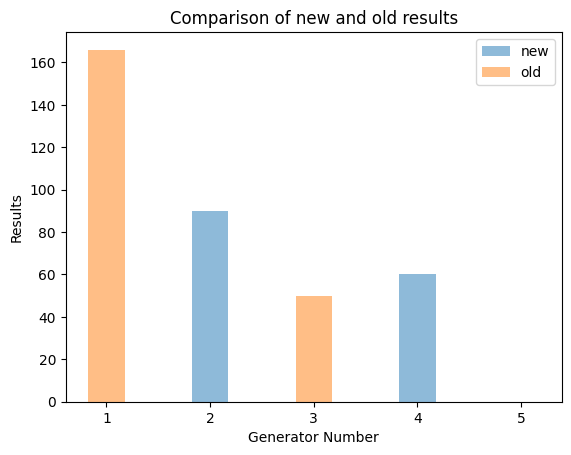

In [36]:
N = 2
demand = 206
#run this block, N is number of bins, "classical" for classical solution, "quantum" for quantum solution, demand from generators, line switching on or off
main(N, "quantum", demand, "on")

In [18]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/tn1': {'shots': 5400, 'tasks': {'COMPLETED': 54}, 'execution_duration': datetime.timedelta(seconds=999, microseconds=959000), 'billed_execution_duration': datetime.timedelta(seconds=999, microseconds=959000)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 4.58 USD
